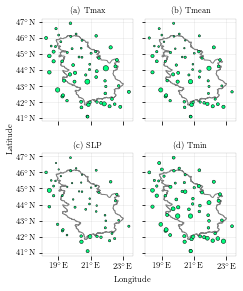

In [17]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from math import sqrt
SPINE_COLOR = 'gray'

import warnings
warnings.filterwarnings('ignore')

def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.33 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'axes.linewidth' : 0.1,
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

### Station-wise RMSE

var_list = ['tmax', 'tmean', 'slp', 'tmin']
gdf = gpd.GeoDataFrame.from_file('../../../MeteoSerbia1km/borders/osm_nominatim/Polygon.shp')

df = pd.read_csv('../../data/serbia/ogimet_serbia08_tmax.csv.gz')
df_loc = df.drop_duplicates(subset=['staid']).set_index('staid')
gdf2 = gpd.GeoDataFrame(
    df_loc, geometry=gpd.points_from_xy(df_loc.lon, df_loc.lat))

latexify(3.3, 4)
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
ax = ax.ravel()
fl = ['(a)', '(b)', '(c)', '(d)']
for i in range(4):
    var = var_list[i]
    if var != 'slp':
        ax[i].set_title(fl[i]+' '+var.capitalize())
    else:
        ax[i].set_title(fl[i]+' SLP')
    var_data = pd.read_csv('../../results/experiment-2/ogimet_'+var+'.csv')
    df_loc['rmse'] = None
    rmse = []
    for staid in df_loc.index:
        try:
            tmp_df = var_data[var_data.staid == staid]
            rmse.append(mean_squared_error(tmp_df[var].values, tmp_df['pred'].values, squared=False)*5)
        except ValueError:
            rmse.append(0)
    gdf2.plot(markersize=rmse, ax=ax[i], color='springgreen', edgecolor='k', linewidth=0.5)
    gdf.plot(zorder=-1, ax=ax[i], color='w', edgecolor='k', alpha=0.5)
    ax[i].set_xticks(range(19,25,2))
    ax[i].set_xticklabels(map(lambda x: str(x)+'$^{\circ}$E', ax[i].get_xticks()))
    ax[i].set_yticks(range(41, 48))
    ax[i].set_yticklabels(map(lambda x: str(x)+'$^{\circ}$N', ax[i].get_yticks()))
    ax[i].set_aspect("equal")
    ax[i].grid(True, alpha=0.2)
    
fig.text(0.45, 0, 'Longitude')
fig.text(0, 0.45, 'Latitude', rotation='vertical')
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)
fig.tight_layout();

plt.savefig('../../figures/s-wise.pdf', bbox_inches='tight')